In [1]:
import os
import platform
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import pathlib
import pickle #to save files
from itertools import product
from scipy.stats import skew, kurtosis, wilcoxon
from scipy.signal import butter, welch, filtfilt, resample
from scipy import stats
# import xgboost as xgb
# from xgboost.sklearn import XGBClassifier #this is the SKlearn wrapper
from sklearn.metrics import confusion_matrix, auc, f1_score, roc_auc_score, precision_score, recall_score, precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import svm
import time

from PreprocessFcns import *

from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

sns.set_context('talk',font_scale=1)
#-- For interactive plots--
# from mpl_toolkits.mplot3d import Axes3D
# %matplotlib notebook

In [2]:
def LOSOCV(Data,X,y,groups,models,LOin=0):

    subj = LeaveOneGroupOut() 
    results = pd.DataFrame(data=None,columns=['model','f1','auprc','auroc'])
    groupres = {} #results on each group for each model


    #train multiple classifiers
    for m in models:
        acc_all=[]; acc_train=[] 
        f1_test_all=[]; prec_all=[]; rec_all=[]; spec_all=[]; auprc_all=[]; auroc_train_all=[]; 
        auroc_all=[]; fpr_all=[]; tpr_all=[]; fi_all=[]

        clf = m[0]; model_name = m[1]            
        print('Training %s'%model_name)
        s = 0
        #LOSO CV for current classifier
        for train_index, test_index in subj.split(X, y, groups):
        #leave one in:
            if LOin:
                tridx = train_index.copy()
                train_index = test_index.copy()
                test_index = tridx
            Xtr, Xte = X[train_index], X[test_index]
            ytr, yte = y[train_index], y[test_index]
            if len(np.unique(ytr))<2: #skip if no positive or negative examples are available for training
                print('only 1 class available in train data - skipping')
                continue
            clf.fit(Xtr,ytr)
            ypred = clf.predict(Xte)
            yscore = clf.predict_proba(Xte)
            yscore = yscore[:,1]
            
            #accuracy on train set
            ypred_train = clf.predict(Xtr)
            acc_train.append(sum(ypred_train==ytr)/len(ytr))
            auroc_train = roc_auc_score(ytr,clf.predict_proba(Xtr)[:,1])
            
            #f1-score, prec, recall, specificity, auprc, auroc
            f1_test_all.append(f1_score(yte,ypred))
            precision, recall, _ = precision_recall_curve(yte,yscore)
            auprc = auc(recall,precision)
            if len(np.unique(yte))>1:
                auroc = roc_auc_score(yte,yscore)
            else:
                print('only 1 class in test data - cannot compute roc curve')
                auroc = np.nan
            spec = sum((ypred==0) & (yte==0))/sum(yte==0)


            prec_all.append(precision_score(yte,ypred))
            rec_all.append(recall_score(yte,ypred))
            auprc_all.append(auprc)
            auroc_all.append(auroc)
            auroc_train_all.append(auroc_train)
            spec_all.append(spec)
            
            #the recall per task - TO BE COMPLETED
            
#             tasks=Data.iloc[test_index,:].Task
#             for t in tasks.unique():
#                 tasks
            
            #compute ROC points at fixed fpr (to plot error bars)
            fpr=np.linspace(0,1,101); tpr=[]

            if len(np.unique(yte))>1:                
                nscores = np.sort(np.column_stack((yscore[yte==0],yte[yte==0])),axis=0)
                neg_counts = sum(yte==0)
                for f in fpr:
                    ind = neg_counts-int(neg_counts*f)-1
                    t = (nscores[ind])[0]
                    if f==1:
                        t = 0
                    tpr_t = sum(yscore[yte==1]>t) / sum(yte==1)
                    tpr.append(tpr_t) 

            fpr = np.asarray(fpr); tpr = np.asarray(tpr)
            fpr_all.append(fpr); tpr_all.append(tpr)
            
            #store feature importance
            if model_name != 'SVM':
                fi_all.append(clf.feature_importances_)
            
            print('\nSubj/Visit %d, prec=%.3f, rec=%.3f, Spec=%.3f, auroc_train=%.3f, auroc=%.3f'%(s,precision_score(yte,ypred),recall_score(yte,ypred),
                                                                                 spec,auroc_train,auroc))
            s+=1

        print('f1_test=%.3f+/-%.3f, prec=%.3f+/-%.3f, rec=%.3f+/-%.3f, auprc=%.3f+/-%.3f, auroc=%.3f+/-%.3f'%(
        np.nanmean(f1_test_all),np.nanstd(f1_test_all),
        np.nanmean(prec_all),np.nanstd(prec_all), np.nanmean(rec_all),np.nanstd(rec_all),
        np.nanmean(auprc_all),np.nanstd(auprc_all), np.nanmean(auroc_all),np.nanstd(auroc_all)))
        
        #group results for each model
        groupres[model_name] = {'f1':f1_test_all, 'auprc':auprc_all, 'auroc':auroc_all, 'tpr':tpr_all, 'fpr':fpr_all, 
                                'rec':rec_all, 'spec':spec_all, 'fi':fi_all}
        
        #mean across groups for each model
        r = pd.DataFrame({'model':model_name, 'f1':np.nanmean(f1_test_all), 'auprc':np.nanmean(auprc_all), 'auroc':np.nanmean(auroc_all)}
                        ,index=[0])
        results = pd.concat((results,r))
        
    return results,groupres 
    

#train multiple classifiers using stratified kfold
def trainmodel_Kfold(Xf,y,models,nfolds=5,balance=False):

    scaler = StandardScaler()
    f1_fold_clf=[]; auc_fold_clf=[]; cmats={}

    skf = StratifiedKFold(n_splits=nfolds,shuffle=True,random_state=46)
        
    for clf,model_name in models:
        f1_fold = []; f1_train_fold=[]; prec_fold=[]; rec_fold=[]; auprc_fold=[]

        for train_idx,test_idx in skf.split(Xf,y):
            Xtr = Xf[train_idx]
            ytr = y[train_idx]
            if balance:
                #balance dataset
                indsp = np.where(ytr==1)[0]
                indsn = np.random.choice(np.where(ytr==0)[0],size=round(1*len(indsp)),replace=False)
                inds = np.hstack((indsp,indsn))
                Xtr = Xtr[inds]; ytr = ytr[inds]
#             print(len(ytr[ytr==0])/len(ytr[ytr>0]))
            Xte = Xf[test_idx]
            yte = y[test_idx]
            Xtr = scaler.fit_transform(Xtr)
            Xte = scaler.transform(Xte)
            clf.fit(Xtr,ytr)
            ypred_train = clf.predict(Xtr)
            ypred = clf.predict(Xte)
            yscore = clf.predict_proba(Xte)
            yscore = yscore[:,1]
            
            #accuracy on train and test set for current fold
            precision, recall, _ = precision_recall_curve(yte,yscore)
            
            f1_train_fold.append(f1_score(ytr,ypred_train))
            f1_fold.append(f1_score(yte,ypred))
            prec_fold.append(precision_score(yte,ypred))
            rec_fold.append(recall_score(yte,ypred))
            auprc_fold.append(auc(recall,precision)
)


        #mean accuracy across folds
        if balance:
            print('Npos = %d, Nneg = %d'%(len(indsp),len(indsn)))
            
        print('%s'%model_name)
        print('f1_train=%.3f+/-%.3f, f1_test=%.3f+/-%.3f, prec=%.3f+/-%.3f, rec=%.3f+/-%.3f, auprc=%.3f+/-%.3f'%(
        np.nanmean(f1_train_fold),np.nanstd(f1_train_fold),
        np.nanmean(f1_fold),np.nanstd(f1_fold),
        np.nanmean(prec_fold),np.nanstd(prec_fold), np.nanmean(rec_fold),np.nanstd(rec_fold),
        np.nanmean(auprc_fold),np.nanstd(auprc_fold)))
        
        cf_matrix = confusion_matrix(yte, ypred)
        print(cf_matrix)
        #store f1 and auc for each fold and clf
        f1_fold_clf.append(f1_fold)
        auc_fold_clf.append(auprc_fold)
        #store cmat for each clf (on last fold)
        cmats.update({model_name:cf_matrix})
        
    return f1_fold_clf, auc_fold_clf, cmats

    
    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    

def plot_roc(tpr_all,fpr,roc_auc,ax=None,plotname=None,col=None):
    #plot mean ROC across subjects (need to add shaded conf interval)
    tprmu = np.mean(np.asarray(tpr_all),axis=0)
    tpr=np.asarray(tpr_all)
    fpr=np.reshape(fpr,(1,-1))
    tprmu=np.reshape(tprmu,(1,-1))
    label=pd.Series(data = ['%s - AUC = %0.3f' % (plotname,roc_auc)]*len(fpr))
    if plotname=='Threshold':
        ls = '-'
    else:
        ls='-'
    if ax == None:
        ax = sns.tsplot(data=tpr,time=fpr,ci=95,condition=label,legend=True,color=col,lw=3,linestyle=ls)
    else:
        sns.tsplot(data=tpr,time=fpr,ci=95,condition=label, legend=True,ax=ax,color=col,lw=3,linestyle=ls)
             
    lw = 3
    
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax.set_xlim([-0.05, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate',fontsize=16)
    ax.set_ylabel('True Positive Rate',fontsize=16)
    ax.legend(loc='lower right')
    
    return ax

def LOSOCV_Tasks(Data,X,y,groups,tasks,clf):

    subj = LeaveOneGroupOut() 
    results = pd.DataFrame(data=None,columns=['model','f1','auprc','auroc'])
    groupres = {} #results on each group for each task subset


    #train multiple classifiers
    for T in tasks:
        acc_all=[]; acc_train=[] 
        f1_test_all=[]; prec_all=[]; rec_all=[]; spec_all=[]; auprc_all=[]; auroc_train_all=[]; 
        auroc_all=[]; fpr_all=[]; tpr_all=[]; fi_all=[]
          
        s = 0
        #LOSO CV for current classifier
        for train_index, test_index in subj.split(X, y, groups):
            task_inds = Data.Task.iloc[test_index]==T[0]
            for Ti in T[1::]:
                task_inds = task_inds | (Data.Task.iloc[test_index]==Ti)
            test_index = test_index[task_inds]
            Xtr, Xte = X[train_index], X[test_index]
            ytr, yte = y[train_index], y[test_index]
            if len(np.unique(ytr))<2: #skip if no positive or negative examples are available for training
                print('only 1 class available in train data - skipping')
                continue
            clf.fit(Xtr,ytr)
            ypred = clf.predict(Xte)
            yscore = clf.predict_proba(Xte)
            yscore = yscore[:,1]

            #accuracy on train set
            ypred_train = clf.predict(Xtr)
            acc_train.append(sum(ypred_train==ytr)/len(ytr))
            auroc_train = roc_auc_score(ytr,clf.predict_proba(Xtr)[:,1])

            #f1-score, prec, recall, specificity, auprc, auroc
            f1_test_all.append(f1_score(yte,ypred))
            precision, recall, _ = precision_recall_curve(yte,yscore)
            auprc = auc(recall,precision)
            if len(np.unique(yte))>1:
                auroc = roc_auc_score(yte,yscore)
            else:
                print('only 1 class in test data - cannot compute roc curve')
                auroc = np.nan
            spec = sum((ypred==0) & (yte==0))/sum(yte==0)


            prec_all.append(precision_score(yte,ypred))
            rec_all.append(recall_score(yte,ypred))
            auprc_all.append(auprc)
            auroc_all.append(auroc)
            auroc_train_all.append(auroc_train)
            spec_all.append(spec)

            #the recall per task - TO BE COMPLETED

#             tasks=Data.iloc[test_index,:].Task
#             for t in tasks.unique():
#                 tasks

            #compute ROC points at fixed fpr (to plot error bars)
            fpr=np.linspace(0,1,101); tpr=[]

            if len(np.unique(yte))>1:                
                nscores = np.sort(np.column_stack((yscore[yte==0],yte[yte==0])),axis=0)
                neg_counts = sum(yte==0)
                for f in fpr:
                    ind = neg_counts-int(neg_counts*f)-1
                    t = (nscores[ind])[0]
                    if f==1:
                        t = 0
                    tpr_t = sum(yscore[yte==1]>t) / sum(yte==1)
                    tpr.append(tpr_t) 

            fpr = np.asarray(fpr); tpr = np.asarray(tpr)
            fpr_all.append(fpr); tpr_all.append(tpr)

            #store feature importance
            if model_name != 'SVM':
                fi_all.append(clf.feature_importances_)

            s+=1

        #group results for each model
        groupres[tuple(T)] = {'f1':f1_test_all, 'auprc':auprc_all, 'auroc':auroc_all, 'tpr':tpr_all, 'fpr':fpr_all, 
                                'rec':rec_all, 'spec':spec_all, 'fi':fi_all}

        #mean across groups for each model
        r = pd.DataFrame({'model':model_name, 'f1':np.nanmean(f1_test_all), 'auprc':np.nanmean(auprc_all), 'auroc':np.nanmean(auroc_all)}
                        ,index=[0])
        results = pd.concat((results,r))
        
    return results,groupres 
    

In [3]:
from sklearn.model_selection import LeaveOneGroupOut
from sklearn import preprocessing
from sklearn import neighbors, linear_model
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.linear_model import ElasticNetCV, LogisticRegression
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix

In [23]:
os.listdir('//FS2.smpp.local/RTO/CIS-PD Study/Clinic WACC features/')

['FeaturesHP_All_subjs.csv',
 'FeaturesLP_NU_subjs.csv',
 'FeaturesLP_All_subjs.csv',
 'FeaturesHP_NU_subjs.csv',
 'WatchClinicFeatHP.hdf']

In [24]:
Data = pd.read_csv('//FS2.smpp.local/RTO/CIS-PD Study/Clinic WACC features/FeaturesLP_NU_subjs.csv',index_col=0)

In [25]:
Dataorig = Data.copy()

In [26]:
Data.head()

,Subject,Visit,Task,Bradykinesia,Tremor,RMSX,RMSY,RMSZ,rangeX,rangeY,...,Dom_freq,Pdom_rel,PSD_mean,PSD_std,PSD_skew,PSD_kur,jerk_mean,jerk_std,jerk_skew,jerk_kur
0,1004,2 Weeks: Time 0,Stndg,NaN,0.0,0.018733,0.060188,0.003313,0.136214,0.040687,...,2.391948,0.223223,0.000002,0.000004,3.181703,9.952851,-0.000021,0.001249,-0.305824,3.487505
1,1004,2 Weeks: Time 0,Stndg,NaN,0.0,0.015289,0.059997,0.012613,0.229941,0.279938,...,1.400592,0.159269,0.000003,0.000005,2.166399,4.211400,-0.000144,0.002210,-1.134122,3.088913
2,1004,2 Weeks: Time 0,Stndg,NaN,0.0,0.035065,0.043751,0.028815,0.811841,1.008188,...,1.200507,0.187769,0.000115,0.000247,2.719595,6.691287,0.000138,0.005349,0.714117,5.235909
3,1004,2 Weeks: Time 0,Stndg,NaN,0.0,0.039675,0.026592,0.041062,0.778816,0.730810,...,1.200532,0.220734,0.000152,0.000367,2.901959,7.596116,0.000092,0.006588,0.379673,1.602858
4,1004,2 Weeks: Time 0,Stndg,NaN,0.0,0.027967,0.036291,0.043064,0.702907,0.574778,...,1.200532,0.161936,0.000023,0.000049,2.234340,3.675815,-0.000192,0.004245,-0.081430,3.191038


In [27]:
np.sort(Data.Subject.unique())

array([1004, 1016, 1018, 1019, 1020, 1024, 1029, 1030, 1032, 1038, 1044,
       1046, 1049, 1051], dtype=int64)

In [28]:
#remove 1020
Data=Data[Data.Subject!=1020]

In [29]:
len(Data)

14055

In [30]:
len(Data.Subject.unique())

13

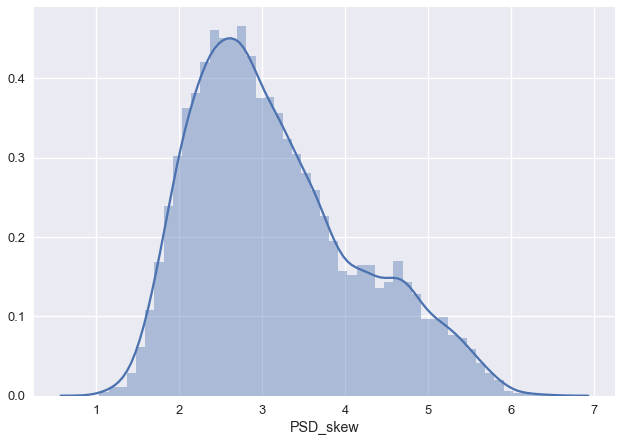

In [31]:
#sanity check
sns.distplot(Data.PSD_skew)

### Bradykinesia - HP filtered features 

In [19]:
t1=time.time()
res_all = pd.DataFrame()

Data=Data.reset_index(drop=True) #reset index

for symptom in ['Bradykinesia']:
    
    #remove nan rows for current symptom
    Data = Dataorig.copy() #original unmodified dataframe
    Data=Data[~Data[symptom].isnull()]
    Data=Data.reset_index(drop=True) #reset index
    
    X = Data.iloc[:,5:].as_matrix()
    # X = StandardScaler().fit_transform(X)
    fnames = Data.iloc[:,7:].columns.values

    indp = ((Data[symptom]>0))
    indp = indp.values
    y = indp.astype(int) #target 
    print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

    models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
#           XGBClassifier()]
    model_name = ['Random Forest']#,'XGB']
    models = list(zip(models,model_name))
    groups = Data.Subject.as_matrix()

    res,res_group = LOSOCV(Data,X,y,groups,models)
    res_all = pd.concat((res_all,res))
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

Rows w Bradykinesia 5932/10714 = 0.55
Training Random Forest

Subj/Visit 0, prec=0.403, rec=0.522, Spec=0.660, auroc_train=1.000, auroc=0.616

Subj/Visit 1, prec=0.929, rec=0.793, Spec=0.669, auroc_train=1.000, auroc=0.790

Subj/Visit 2, prec=0.926, rec=0.694, Spec=0.709, auroc_train=1.000, auroc=0.744

Subj/Visit 3, prec=0.654, rec=0.845, Spec=0.344, auroc_train=1.000, auroc=0.590

Subj/Visit 4, prec=0.553, rec=0.781, Spec=0.246, auroc_train=1.000, auroc=0.606

Subj/Visit 5, prec=0.717, rec=0.832, Spec=0.503, auroc_train=1.000, auroc=0.743

Subj/Visit 6, prec=0.721, rec=0.644, Spec=0.645, auroc_train=1.000, auroc=0.664

Subj/Visit 7, prec=0.644, rec=0.915, Spec=0.333, auroc_train=1.000, auroc=0.669

Subj/Visit 8, prec=0.823, rec=0.701, Spec=0.467, auroc_train=1.000, auroc=0.621

Subj/Visit 9, prec=0.069, rec=0.661, Spec=0.326, auroc_train=1.000, auroc=0.504

Subj/Visit 10, prec=0.081, rec=0.918, Spec=0.380, auroc_train=1.000, auroc=0.750

Subj/Visit 11, prec=0.512, rec=0.366, Spec=0.5

(0.45, 1)

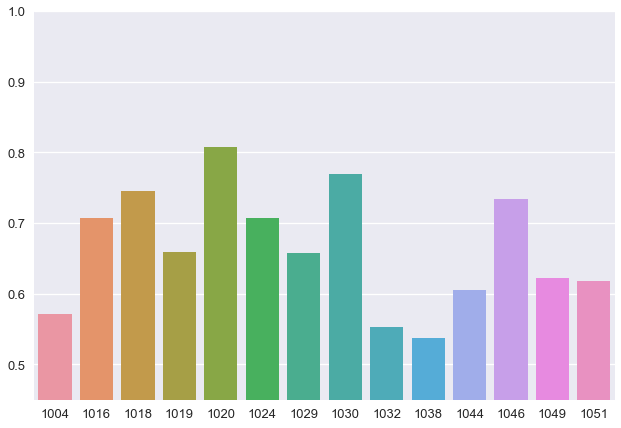

In [39]:
sns.barplot(x=Data.Subject.unique(),y=res_group['Random Forest']['auroc'])
plt.ylim([0.45,1])

### Bradykinesia - LP filtered features 

In [32]:
t1=time.time()
res_all = pd.DataFrame()

Data=Data.reset_index(drop=True) #reset index

for symptom in ['Bradykinesia']:
    
    #remove nan rows for current symptom
    Data = Dataorig.copy() #original unmodified dataframe
    Data=Data[~Data[symptom].isnull()]
    Data=Data.reset_index(drop=True) #reset index
    
    X = Data.iloc[:,5:].as_matrix()
    # X = StandardScaler().fit_transform(X)
    fnames = Data.iloc[:,7:].columns.values

    indp = ((Data[symptom]>0))
    indp = indp.values
    y = indp.astype(int) #target 
    print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

    models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
#           XGBClassifier()]
    model_name = ['Random Forest']#,'XGB']
    models = list(zip(models,model_name))
    groups = Data.Subject.as_matrix()

    res,res_group = LOSOCV(Data,X,y,groups,models)
    res_all = pd.concat((res_all,res))
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

Rows w Bradykinesia 5932/10714 = 0.55
Training Random Forest

Subj/Visit 0, prec=0.366, rec=0.453, Spec=0.655, auroc_train=1.000, auroc=0.571

Subj/Visit 1, prec=0.917, rec=0.749, Spec=0.629, auroc_train=1.000, auroc=0.707

Subj/Visit 2, prec=0.919, rec=0.588, Spec=0.730, auroc_train=1.000, auroc=0.746

Subj/Visit 3, prec=0.662, rec=0.923, Spec=0.309, auroc_train=1.000, auroc=0.659

Subj/Visit 4, prec=0.750, rec=0.740, Spec=0.705, auroc_train=1.000, auroc=0.807

Subj/Visit 5, prec=0.683, rec=0.795, Spec=0.442, auroc_train=1.000, auroc=0.707

Subj/Visit 6, prec=0.671, rec=0.658, Spec=0.540, auroc_train=1.000, auroc=0.658

Subj/Visit 7, prec=0.701, rec=0.958, Spec=0.463, auroc_train=1.000, auroc=0.769

Subj/Visit 8, prec=0.818, rec=0.773, Spec=0.392, auroc_train=1.000, auroc=0.552

Subj/Visit 9, prec=0.075, rec=0.712, Spec=0.339, auroc_train=1.000, auroc=0.538

Subj/Visit 10, prec=0.068, rec=0.653, Spec=0.464, auroc_train=1.000, auroc=0.605

Subj/Visit 11, prec=0.730, rec=0.486, Spec=0.7

### Tremor - HP filtered features

In [20]:
t1=time.time()
res_all = pd.DataFrame()

Data=Data.reset_index(drop=True) #reset index

for symptom in ['Tremor']:
    
    #remove nan rows for current symptom
    Data = Dataorig.copy() #original unmodified dataframe
    Data=Data[~Data[symptom].isnull()]
    Data=Data.reset_index(drop=True) #reset index
    
    X = Data.iloc[:,5:].as_matrix()
    # X = StandardScaler().fit_transform(X)
    fnames = Data.iloc[:,7:].columns.values

    indp = ((Data[symptom]>0))
    indp = indp.values
    y = indp.astype(int) #target 
    print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

    models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
#           XGBClassifier()]
    model_name = ['Random Forest']#,'XGB']
    models = list(zip(models,model_name))
    groups = Data.Subject.as_matrix()

    res,res_group = LOSOCV(Data,X,y,groups,models)
    res_all = pd.concat((res_all,res))
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

Rows w Tremor 3852/14204 = 0.27
Training Random Forest

Subj/Visit 0, prec=0.201, rec=0.453, Spec=0.822, auroc_train=1.000, auroc=0.689

Subj/Visit 1, prec=0.748, rec=0.174, Spec=0.965, auroc_train=1.000, auroc=0.786

Subj/Visit 2, prec=0.610, rec=0.323, Spec=0.960, auroc_train=1.000, auroc=0.860

Subj/Visit 3, prec=0.304, rec=0.369, Spec=0.943, auroc_train=1.000, auroc=0.751

Subj/Visit 4, prec=0.375, rec=0.182, Spec=0.625, auroc_train=1.000, auroc=0.402

Subj/Visit 5, prec=0.584, rec=0.366, Spec=0.867, auroc_train=1.000, auroc=0.725

Subj/Visit 6, prec=0.646, rec=0.392, Spec=0.826, auroc_train=1.000, auroc=0.731

Subj/Visit 7, prec=0.786, rec=0.733, Spec=0.980, auroc_train=1.000, auroc=0.981

Subj/Visit 8, prec=0.400, rec=0.722, Spec=0.944, auroc_train=1.000, auroc=0.930

Subj/Visit 9, prec=0.919, rec=0.460, Spec=0.952, auroc_train=1.000, auroc=0.860


C:\Users\llonini\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\llonini\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:415: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\llonini\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:96: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\llonini\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1115: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 10, prec=0.000, rec=0.000, Spec=0.898, auroc_train=1.000, auroc=nan

Subj/Visit 11, prec=0.231, rec=0.074, Spec=0.823, auroc_train=1.000, auroc=0.245

Subj/Visit 12, prec=0.941, rec=0.533, Spec=0.884, auroc_train=1.000, auroc=0.854

Subj/Visit 13, prec=0.000, rec=0.000, Spec=0.923, auroc_train=1.000, auroc=0.666
f1_test=0.370+/-0.227, prec=0.482+/-0.302, rec=0.342+/-0.227, auprc=0.507+/-0.261, auroc=0.729+/-0.197
Elapsed time = 0.926 min


In [26]:
res_group['Random Forest']['auroc']

[0.5163760759214302,
 0.62827160897729517,
 nan,
 0.87037037037037046,
 0.52470142513046969,
 0.77142295912640513,
 0.72765957446808527,
 0.55447915606661924,
 0.62216483269705813,
 nan,
 0.74623082742967195,
 0.66430196844029399,
 0.63106416275430366,
 0.63604357298474945,
 0.46441548269184735,
 nan,
 nan,
 0.74493520035751526,
 0.60562792470687199,
 nan,
 0.40323539200304281,
 0.6990026632636076]